In [10]:
import pandas as pd
import numpy as np
data_dir="/data/home/jinyalong/data/sev_241110"
# data_dir="/data/home/jinyalong/data/sev_240624"

columns = ["seq","score","plasmid_counts","rna_counts"]
# sname = "pl4-3" # 2-D11,pl3-1,pl4-3
# name1,name2,name=f"{sname}-1",f"{sname}-2",f"{sname}-merge"
# rna1 = pd.read_csv(f"{data_dir}/results/{name1}/{name1}_final.csv")[columns]
# rna2 = pd.read_csv(f"{data_dir}/results/{name2}/{name2}_final.csv")[columns]

name1,name2,name=f"1-D5_final",f"2-D11_final",f"exp12-merge"
rna1 = pd.read_csv(f"{data_dir}/results/{name}/{name1}.csv")[columns]
rna2 = pd.read_csv(f"{data_dir}/results/{name}/{name2}.csv")[columns]

mdna,nrna,threshold=5,0,2.5
rna1=rna1[(rna1["plasmid_counts"]>=mdna)&(rna1["rna_counts"]>=nrna)]
rna2=rna2[(rna2["plasmid_counts"]>=mdna)&(rna2["rna_counts"]>=nrna)]
rrna1=rna1[["seq","score","plasmid_counts","rna_counts"]].rename(
    columns={"score":"score1","plasmid_counts":"plasmid_counts1","rna_counts":"rna_counts1"})
rrna2=rna2[["seq","score","plasmid_counts","rna_counts"]].rename(
    columns={"score":"score2","plasmid_counts":"plasmid_counts2","rna_counts":"rna_counts2"})

df = pd.merge(rrna1,rrna2,on="seq")
df["bias"]=df.apply(lambda x:abs(x["score1"]-x["score2"]),axis=1)
df["score"]=(df["score1"]+df["score2"])/2
df["plasmid_counts"]=(df["plasmid_counts1"]+df["plasmid_counts2"])
df["rna_counts"]=(df["rna_counts1"]+df["rna_counts2"])
rna1 = rna1[~rna1.seq.isin(set(df.seq.values))]
rna2 = rna2[~rna2.seq.isin(set(df.seq.values))]
rna1["flag"] = 1
rna2["flag"] = 2
ndf = df[df.bias<threshold].copy()
mdf = ndf[columns].copy()
mdf["flag"]= 0
# mdf = ndf
mdf = pd.concat([mdf,rna1,rna2])
mdf.to_csv(f"{data_dir}/results/{name}/{name}_final.csv",index=False)

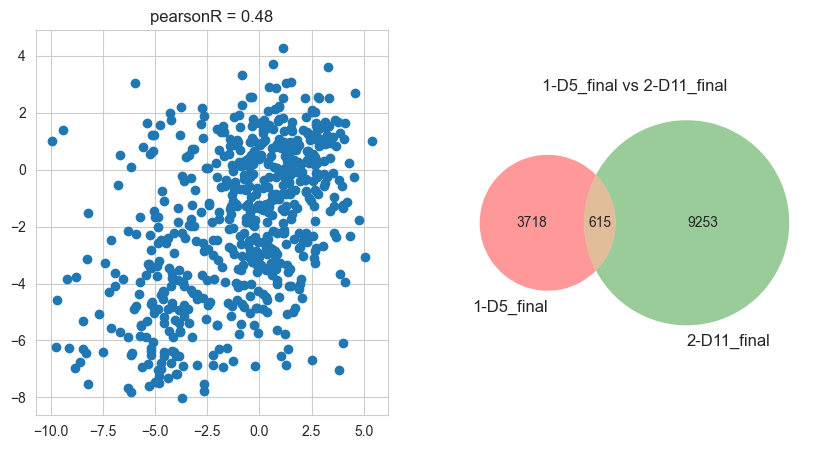

In [11]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import scipy.stats as stats
pdf = df
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
pr =  stats.pearsonr(pdf["score1"],pdf["score2"])
plt.title(f"pearsonR = {pr[0]:.2f}")
plt.scatter(pdf["score1"], pdf["score2"], marker='o')
plt.subplot(1,2,2)
plt.title(f"{name1} vs {name2}")
venn2([set(rrna1.seq.values), set(rrna2.seq.values)],set_labels = (name1, name2))
plt.show()

(12007, 5) (1335, 5)


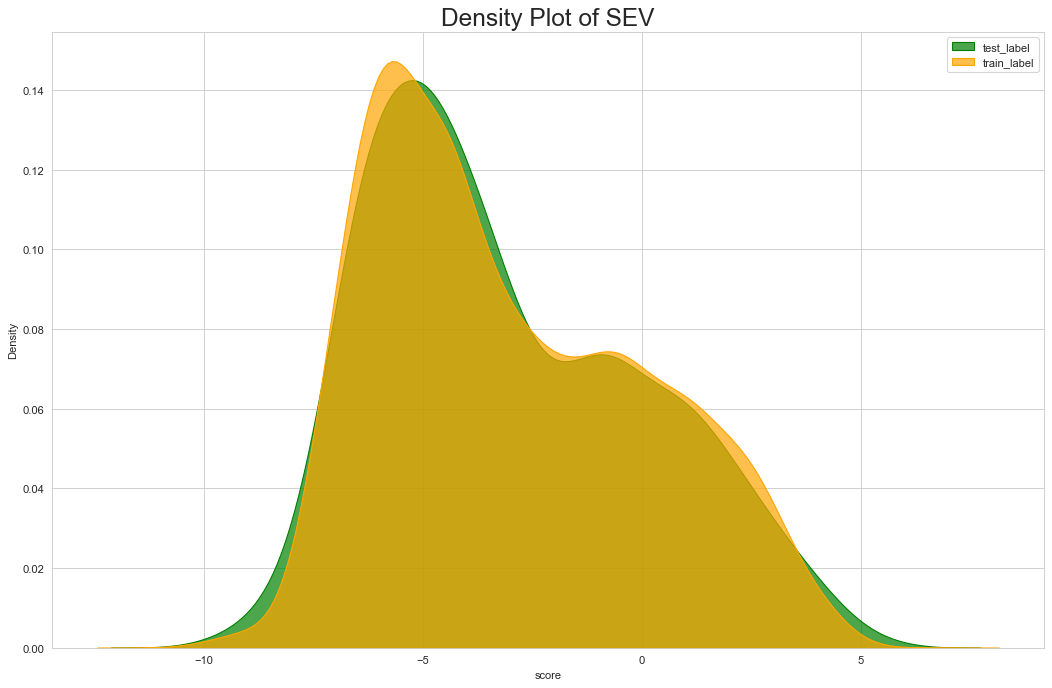

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit,ShuffleSplit
df = pd.read_csv(f"{data_dir}/results/{name}/{name}_final.csv")
# df=df[(df["plasmid_counts"]>=10)&(df["rna_counts"]>=0)]
split = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, test_idx in split.split(df):
    e_train = df.iloc[train_idx].reset_index(drop=True)
    e_test = df.iloc[test_idx].reset_index(drop=True)
print(e_train.shape, e_test.shape)
e_train.to_csv(f"{data_dir}/results/{name}/{name}_train.csv",index=False)
e_test.to_csv(f"{data_dir}/results/{name}/{name}_test.csv",index=False)
label = "score" # abs_score,length, score
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(e_test[label], fill=True, color="g", label="test_label", alpha=.7)
sns.kdeplot(e_train[label], fill=True, color="orange", label="train_label", alpha=.7)
# Decoration
plt.title('Density Plot of SEV', fontsize=22)
plt.legend()
plt.show()